!pip install --no-cache-dir --upgrade git+https://github.com/Evfro/polara.git@develop#egg=polara  
!pip install ipypb

In [1]:
import numpy as np
import pandas as pd

from polara import get_movielens_data, RecommenderData, SVDModel
from polara.recommender.models import RandomSampleEvaluationSVDMixin
from polara.recommender.data import RandomSampleEvaluationMixin
from polara.evaluation.pipelines import find_optimal_svd_rank

try:
    from ipypb import track
except ImportError:
    from tqdm.auto import tqdm as track
    
from dataprep import split_holdout, sample_unseen_interactions

---
The following setup is based on experiment description from the RecWalk paper:  
_"RecWalk: Nearly Uncoupled Random Walks for Top-N Recommendation"_; Athanasios N. Nikolakopoulos, George Karypis; WSDM '19.  
Where necessary, quotes from the original paper are provided.
---

In [2]:
# data config
feedback = 'rating'
# randomization control
seed = 0
holdout_seed = 42 # to sample unseen items for holdout
# sampling settings
sample_max_rated = True
rating_threshold = 0 # for ratings [1, 2, 3, 4, 5]
# evaluation setitings
target_metric = 'hr'
svd_ranks = range(5, 101, 5)

Logged results (with kernel restarts):  
```python
seed = 0, holdout_seed = 42

sample_max_rated = True, rating_threshold = 0:  
hr=0.46564000662361316, arhr=0.23904475407207648
```

## Data preprocessing

In [3]:
ml_data = (
    get_movielens_data('D:/datasets/recsys/movielens/ml-1m.zip')
    .query(f'{feedback:s} >= @rating_threshold')
)

## train-test split

Quote:  
`...for each user we randomly select one liked item...and we create a testset T...  
...the per-user ‘liked’ item is randomly sampled among the highest rated items of each particular user...`

Quote:  
`For model selection we repeat the same procedure on the training data and we create a validation set V; and for each method considered we explore the hyperparameter space to find the modelthat yields the best performance in recommending the items in V,and then we evaluate its out-of-sample performance based on the held-out items in T`

In [4]:
rs = np.random.RandomState(seed)
tmp_train, holdout = split_holdout(  # test
    ml_data,
    sample_max_rated = sample_max_rated,
    feedback = feedback,
    random_state = rs
)
train, validation = split_holdout( # validation
    tmp_train, # data without holdout
    sample_max_rated = sample_max_rated,
    feedback = feedback,
    random_state = rs
)

Quote:  
`During training of all competing methods we consider only binary feedback`

In [5]:
train[feedback] = 1 # make data for training implicit

### unseen items sampling

Quote:  
`...we consider for each user her corresponding test item along side 999 randomly sampled unseen items and we rank the 1000 item lists...`

In [6]:
validation_unseen = sample_unseen_interactions(
    ml_data.query('userid in @validation.userid'),
    train.movieid.unique(),
    itemid='movieid', 
    seed=seed)
validation_unseen.head()

userid
1    [47, 1237, 2736, 275, 1125, 1116, 591, 2174, 3...
2    [2951, 3331, 2664, 203, 1004, 3603, 3790, 22, ...
3    [2629, 1676, 1341, 530, 2459, 2130, 2326, 1030...
4    [119, 322, 3382, 3800, 1846, 2679, 2965, 1510,...
5    [889, 3053, 1401, 60, 1674, 217, 3168, 528, 27...
Name: movieid, dtype: object

In [7]:
assert not ( # verify train and validation are disjoint
    train
    .groupby('userid', sort=False)
    .movieid
    .apply(lambda x: x.isin(validation_unseen.loc[x.name]).any()).any()
)

## Data Model Specification

In [8]:
class RandomSampleEvaluationData(
    RandomSampleEvaluationMixin, RecommenderData
): pass

In [9]:
data = RandomSampleEvaluationData(train, *train.columns)
print(data)

RandomSampleEvaluationData with Fields(userid='userid', itemid='movieid', feedback='rating')


In [10]:
data.prepare_training_only()

Preparing data...
Done.
There are 988129 events in the training and 0 events in the holdout.


### setting holdout and unseen interctions

In [11]:
data.set_test_data(holdout=validation, holdout_size=1)

1 unique movieid entities within 1 holdout interactions were filtered. Reason: not in the training data.
Done. There are 6039 events in the holdout.


In [12]:
data.set_unseen_interactions(validation_unseen)

In [13]:
data.unseen_interactions.head()

userid
0    [46, 1146, 2529, 268, 1048, 1040, 577, 1991, 2...
1    [2741, 3103, 2460, 197, 939, 3361, 3545, 21, 7...
2    [2425, 1539, 1243, 516, 2264, 1947, 2131, 965,...
3    [114, 313, 3150, 3555, 1665, 2475, 2752, 1392,...
4    [830, 2837, 1301, 58, 1537, 211, 2950, 514, 25...
Name: movieid, dtype: object

In [14]:
assert data.unseen_interactions.apply(len).eq(999).all()

## PureSVD Model

In [15]:
class RandomSampleEvaluationSVD(
    RandomSampleEvaluationSVDMixin, SVDModel
): pass

In [16]:
svd = RandomSampleEvaluationSVD(data)

### grid search on validation data

In [17]:
best_svd_rank, svd_scores = find_optimal_svd_rank(
    svd,
    svd_ranks,
    target_metric,
    metric_type='main',
    return_scores=True,
    iterator=track
)

 [████████████████████████████████████████████████████████████] 20/20 [00:44<00:02, 2.22s/it]

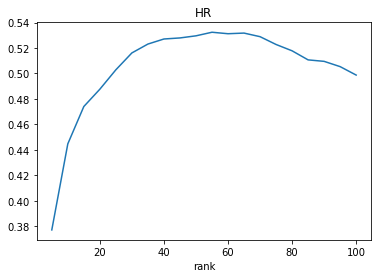

In [18]:
svd_scores.plot(title=target_metric.upper());

### evaluation on withheld data

In [19]:
# add validation data to train
data._data = data._data.append(validation, ignore_index=True)
data.prepare_training_only()

Preparing data...
Done.
There are 994169 events in the training and 0 events in the holdout.


In [20]:
data.set_test_data(holdout=holdout, holdout_size=1)

1 unique movieid entities within 1 holdout interactions were filtered. Reason: not in the training data.
Done. There are 6039 events in the holdout.


In [21]:
holdout_unseen = sample_unseen_interactions(
    ml_data.query('userid in @holdout.userid'),
    data.index.itemid.old.values, # ensure validation is added
    itemid='movieid', 
    seed = holdout_seed
)

In [22]:
assert not ( # verify train and holdout are disjoint
    data._data # take validation split into account
    .groupby('userid', sort=False)
    .movieid
    .apply(lambda x: x.isin(holdout_unseen.loc[x.name]).any()).any()
)

In [23]:
data.set_unseen_interactions(holdout_unseen)
assert data.unseen_interactions.apply(len).eq(999).all()

In [24]:
print(f'Optimal SVD rank: {best_svd_rank}')
svd.rank = best_svd_rank
svd.evaluate(metric_type='main')

Optimal SVD rank: 55
PureSVD model is not ready. Rebuilding.
PureSVD training time: 0.622s


[Relevance(hr=0.46564000662361316),
 Ranking(arhr=0.23904475407207648, mrr=0.23904475407207648)]